In [1]:
#https://huggingface.co/learn/nlp-course/en/chapter6/2
#https://huggingface.co/learn/nlp-course/en/chapter7/6

In [1]:
#!pip install datasets evaluate transformers[sentencepiece]
#!pip install accelerate

In [9]:
from datasets import load_dataset
from transformers import AutoTokenizer

In [5]:
# train tokenizer for python with code_search_net dataset.
raw_datasets = load_dataset("code_search_net", "python", trust_remote_code=True)

python.zip:   0%|          | 0.00/941M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

In [6]:
raw_datasets["train"]

Dataset({
    features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
    num_rows: 412178
})

In [13]:
# iterator to return "whole_func_string" field
def get_training_corpus():
    dataset = raw_datasets["train"]
    for start_idx in range(0, len(dataset), 1000):
        samples = dataset[start_idx : start_idx + 1000]
        yield samples["whole_func_string"]
training_corpus = get_training_corpus()

In [10]:
# load pre-trained gpt2 tokenizer and fine-tune it with python 
old_tokenizer = AutoTokenizer.from_pretrained("gpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/home/bob/tml_venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
example = '''def add_numbers(a, b):
    """Add the two numbers `a` and `b`."""
    return a + b'''

tokens = old_tokenizer.tokenize(example)
tokens

['def',
 'Ġadd',
 '_',
 'n',
 'umbers',
 '(',
 'a',
 ',',
 'Ġb',
 '):',
 'Ċ',
 'Ġ',
 'Ġ',
 'Ġ',
 'Ġ"""',
 'Add',
 'Ġthe',
 'Ġtwo',
 'Ġnumbers',
 'Ġ`',
 'a',
 '`',
 'Ġand',
 'Ġ`',
 'b',
 '`',
 '."',
 '""',
 'Ċ',
 'Ġ',
 'Ġ',
 'Ġ',
 'Ġreturn',
 'Ġa',
 'Ġ+',
 'Ġb']

In [14]:
tokenizer = old_tokenizer.train_new_from_iterator(training_corpus, 52000)

In [15]:
tokens = tokenizer.tokenize(example)
tokens

['def',
 'Ġadd',
 '_',
 'numbers',
 '(',
 'a',
 ',',
 'Ġb',
 '):',
 'ĊĠĠĠ',
 'Ġ"""',
 'Add',
 'Ġthe',
 'Ġtwo',
 'Ġnumbers',
 'Ġ`',
 'a',
 '`',
 'Ġand',
 'Ġ`',
 'b',
 '`."""',
 'ĊĠĠĠ',
 'Ġreturn',
 'Ġa',
 'Ġ+',
 'Ġb']

In [16]:
tokenizer.save_pretrained("code-search-net-tokenizer-python")

('code-search-net-tokenizer-python/tokenizer_config.json',
 'code-search-net-tokenizer-python/special_tokens_map.json',
 'code-search-net-tokenizer-python/vocab.json',
 'code-search-net-tokenizer-python/merges.txt',
 'code-search-net-tokenizer-python/added_tokens.json',
 'code-search-net-tokenizer-python/tokenizer.json')

In [17]:
from huggingface_hub import notebook_login

In [18]:
notebook_login()

In [19]:
tokenizer.push_to_hub("code-search-net-tokenizer-python")

CommitInfo(commit_url='https://huggingface.co/wb-droid/code-search-net-tokenizer-python/commit/4e45022b98c41147c00d382e0ca1de8648141fb3', commit_message='Upload tokenizer', commit_description='', oid='4e45022b98c41147c00d382e0ca1de8648141fb3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/wb-droid/code-search-net-tokenizer-python', endpoint='https://huggingface.co', repo_type='model', repo_id='wb-droid/code-search-net-tokenizer-python'), pr_revision=None, pr_num=None)

In [20]:
tokenizer = AutoTokenizer.from_pretrained("wb-droid/code-search-net-tokenizer-python")

tokenizer_config.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/822k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.67M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [21]:
def any_keyword_in_string(string, keywords):
    for keyword in keywords:
        if keyword in string:
            return True
    return False

In [22]:
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]
example_1 = "import numpy as np"
example_2 = "import pandas as pd"

print(
    any_keyword_in_string(example_1, filters), any_keyword_in_string(example_2, filters)
)

False True


In [23]:
from collections import defaultdict
from tqdm import tqdm
from datasets import Dataset


def filter_streaming_dataset(dataset, filters):
    filtered_dict = defaultdict(list)
    total = 0
    for sample in tqdm(iter(dataset)):
        total += 1
        if any_keyword_in_string(sample["content"], filters):
            for k, v in sample.items():
                filtered_dict[k].append(v)
    print(f"{len(filtered_dict['content'])/total:.2%} of data after filtering.")
    return Dataset.from_dict(filtered_dict)

In [24]:
from datasets import load_dataset, DatasetDict

ds_train = load_dataset("huggingface-course/codeparrot-ds-train", split="train")
ds_valid = load_dataset("huggingface-course/codeparrot-ds-valid", split="validation")

raw_datasets = DatasetDict(
    {
        "train": ds_train,  # .shuffle().select(range(50000)),
        "valid": ds_valid,  # .shuffle().select(range(500))
    }
)

raw_datasets

DatasetDict({
    train: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 606720
    })
    valid: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 3322
    })
})

In [50]:
raw_datasets = DatasetDict(
    {
        "train": ds_train.shuffle().select(range(50000)),
        "valid": ds_valid.shuffle().select(range(500))
    }
)

raw_datasets

DatasetDict({
    train: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 50000
    })
    valid: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 500
    })
})

In [51]:
for key in raw_datasets["train"][0]:
    print(f"{key.upper()}: {raw_datasets['train'][0][key][:200]}")

REPO_NAME: ThomasMiconi/htmresearch
PATH: projects/feedback/feedback_sequences.py
COPIES: 2
SIZE: 26875
CONTENT: 
# Numenta Platform for Intelligent Computing (NuPIC)
# Copyright (C) 2016, Numenta, Inc.  Unless you have an agreement
# with Numenta, Inc., for a separate license for this software code, the
# follo
LICENSE: agpl-3.0


In [52]:
from transformers import AutoTokenizer

context_length = 128
tokenizer = AutoTokenizer.from_pretrained("wb-droid/code-search-net-tokenizer-python")

outputs = tokenizer(
    raw_datasets["train"][:2]["content"],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

Input IDs length: 85
Input chunk lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 15, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 115]
Chunk mapping: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [53]:
def tokenize(element):
    outputs = tokenizer(
        element["content"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}


tokenized_datasets = raw_datasets.map(
    tokenize, batched=True, remove_columns=raw_datasets["train"].column_names
)
tokenized_datasets

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 1373948
    })
    valid: Dataset({
        features: ['input_ids'],
        num_rows: 14706
    })
})

In [54]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

In [55]:
model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 125.8M parameters


In [56]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [57]:
out = data_collator([tokenized_datasets["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

input_ids shape: torch.Size([5, 128])
attention_mask shape: torch.Size([5, 128])
labels shape: torch.Size([5, 128])


In [58]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="codeparrot-ds",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=18,
    evaluation_strategy="steps",
    eval_steps=5_000,
    logging_steps=5_000,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    fp16=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
)

/home/bob/tml_venv/lib/python3.8/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [59]:
trainer.train()

Step,Training Loss,Validation Loss
5000,3.147500,2.279003
10000,2.092400,1.902443
15000,1.782300,1.670940
20000,1.603700,1.577334


TrainOutput(global_step=21468, training_loss=2.116367022374144, metrics={'train_runtime': 70415.1454, 'train_samples_per_second': 19.512, 'train_steps_per_second': 0.305, 'total_flos': 8.9750416195584e+16, 'train_loss': 2.116367022374144, 'epoch': 1.0})

In [60]:
trainer.push_to_hub()

events.out.tfevents.1728127296.DESKTOP-V4D3531.994.1:   0%|          | 0.00/7.42k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/503M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/wb-droid/codeparrot-ds/commit/76add2d933a389a2c7dcba0ccdf61e3333dc0bf5', commit_message='End of training', commit_description='', oid='76add2d933a389a2c7dcba0ccdf61e3333dc0bf5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/wb-droid/codeparrot-ds', endpoint='https://huggingface.co', repo_type='model', repo_id='wb-droid/codeparrot-ds'), pr_revision=None, pr_num=None)

In [61]:
import torch
from transformers import pipeline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
pipe = pipeline(
    "text-generation", model="wb-droid/codeparrot-ds", device=device
)

model.safetensors:   0%|          | 0.00/503M [00:00<?, ?B/s]

In [123]:
txt = """
from sklearn.ensemble import RandomForestRegressor
# fit random forest model with 300 estimators on X, y:
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])


from sklearn.ensemble import RandomForestRegressor
# fit random forest model with 300 estimators on X, y:
# randomized forest model
rng = RandomForestRegressor(max_depth=30, n_estimators=600)
clf =


In [138]:
txt = """\
import pyplot as plt
# create scatter plot with x, y
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

import pyplot as plt
# create scatter plot with x, y
fig, ax = plt.subplots(1, 1)

# create a scatter plot for x,y locations, respectively
x1, y1 = generate_and


In [142]:
txt = """\
import pyplot as plt
# create scatter plot with x, y
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

import pyplot as plt
# create scatter plot with x, y
#ax = plt.axes()
#sns.heatmap(X, Y, **kwargs)

ax.plot(X, Y, c='r', annot=


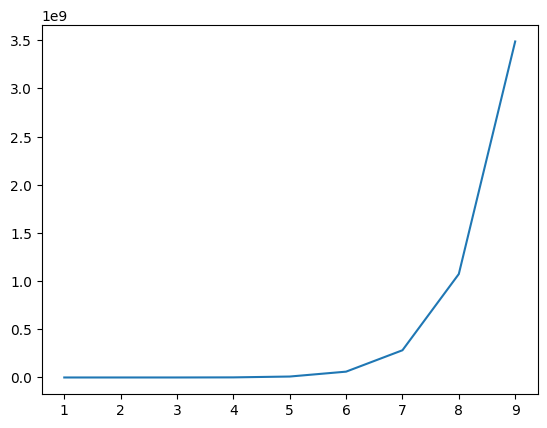

In [158]:
import matplotlib.pyplot as plt 
ax = plt.axes()
X=torch.tensor(range(1,10,1))
Y=X**10 + 1
ax.plot(X,Y)